In [2]:
import os
import sys
import pickle as pkl
import matplotlib.pyplot as plt
sys.path.append("../")

import torch
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import squidpy as sq
import steamboat as sf
import steamboat.tools

In [3]:
import seaborn as sns

In [4]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
matplotlib.rcParams['font.family'] = 'arial'

In [5]:
device = "cuda"

In [6]:
meta = pd.read_csv("sim_meta_rectangle2.csv", index_col=0)
expr = pd.read_csv("sim_expr_rectangle2.csv", index_col=0)

In [7]:
adata = sc.AnnData(expr, obs=meta)
adata.obsm['spatial'] = np.array(meta[['x', 'y']])

adata

AnnData object with n_obs × n_vars = 400 × 13
    obs: 'x', 'y', 'celltype', 'R+'
    obsm: 'spatial'

In [8]:
adatas = [adata]
adatas = sf.prep_adatas(adatas, log_norm=True)
dataset = sf.make_dataset(adatas)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


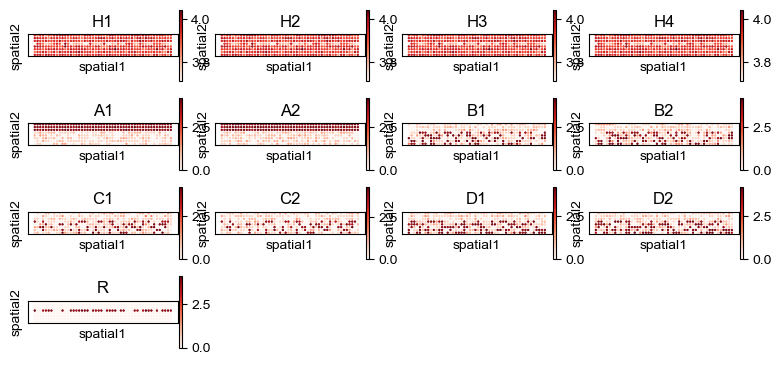

In [9]:
sq.pl.spatial_scatter(adatas[0], color=adatas[0].var_names, shape=None, figsize=(2, 1), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


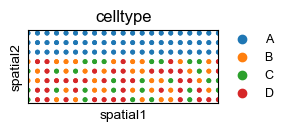

In [23]:
sq.pl.spatial_scatter(adatas[0], color='celltype', shape=None, figsize=(3, 1.2), size=25., 
                      legend_fontsize=9)
plt.xlim([10, 30])
plt.savefig("figures/sim1-celltype.pdf")

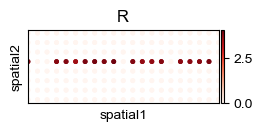

In [24]:
sq.pl.spatial_scatter(adatas[0], color='R', shape=None, figsize=(3, 1.2), size=25., 
                      legend_fontsize=9, cmap='Reds')
plt.xlim([10, 30])
plt.savefig("figures/sim1-R.pdf")

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
[2024-10-06 01:44:04,327::train::INFO] Epoch 1: train_loss 3.95802, reg 0.000000
[2024-10-06 01:44:05,097::train::INFO] Epoch 201: train_loss 0.33273, reg 0.000000
[2024-10-06 01:44:05,693::train::INFO] Epoch 401: train_loss 0.33731, reg 0.000000
[2024-10-06 01:44:06,290::train::INFO] Epoch 601: train_loss 0.29487, reg 0.000000
[2024-10-06 01:44:06,945::train::INFO] Epoch 801: train_loss 0.25162, reg 0.000000
[2024-10-06 01:44:07,581::train::INFO] Epoch 1001: train_loss 0.26546, reg 0.000000
[2024-10-06 01:44:08,232::train::INFO] Epoch 1201: train_loss 0.25208, reg 0.000000
[2024-10-06 01:44:08,935::train::INFO] Epoch 1401: train_loss 0.28805, reg 0.000000
[2024-10-06 01:44:09,588::train::INFO] Epoch 1601: train_loss 0.23574, reg 0.000000
[2024-10-06 01:44:09,927::train::INF

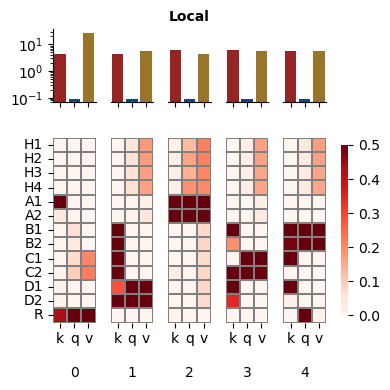

In [71]:
sf.set_random_seed(5)
model = sf.Steamboat(adata.var_names.tolist(), d_ego=0, d_local=5, d_global=0)
model = model.to(device)
model.fit(dataset, masking_rate=0.25, masking_method='full', similarity_penalty=0., max_epoch=10000, 
                      opt=torch.optim.Adam, opt_args=dict(lr=0.1), stop_eps=1e-5, report_per=200, stop_tol=1000)
model.fit(dataset, masking_rate=0.25, masking_method='feature', similarity_penalty=0., max_epoch=5000, 
                      opt=torch.optim.Adam, opt_args=dict(lr=0.001), stop_eps=1e-5, report_per=50, stop_tol=200)

sf.tools.plot_transforms(model, figsize=(4, 4), vmin=0.0, vmax=.5, top=0)

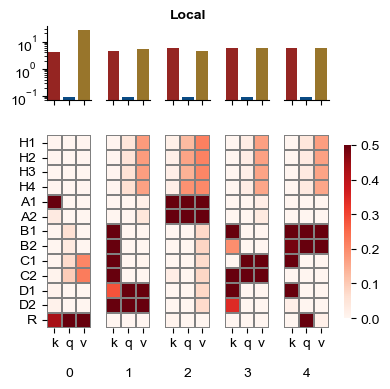

In [110]:
sf.tools.plot_transforms(model, figsize=(4, 4), vmin=0.0, vmax=.5, top=0)
plt.savefig('figures/sim1-loadings.pdf')

In [80]:
sf.tools.annotate_adatas(adatas, dataset, model, get_recon=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.99it/s]


In [81]:
d_ego = model.spatial_gather.d_ego
d_local = model.spatial_gather.d_local
d_global = model.spatial_gather.d_global
res = np.zeros([len(adatas), d_local])
for j in range(len(adatas)):
    for i in range(d_local):
        nonzero_mask = adatas[j].obsm['X_local_q'][:, i] >= 0
        res[j, i] = sp.stats.spearmanr(adatas[j].obsm['X_local_q'][nonzero_mask, i], 
                                            adatas[j].obsm['X_local_attn'][nonzero_mask, i]).statistic

In [58]:
for i in range(len(adatas)):
    sq.gr.spatial_autocorr(adatas[i], mode='moran', layer='X_local_k', attr='obsm', n_jobs=6)
    
moranis = []
for i in range(len(adatas)):
    moranis.append(adatas[i].uns['moranI'].sort_index()['I'].tolist())
    
moranis = np.array(moranis)
moranis

array([[0.81306105, 0.69541621, 0.78061779, 0.63892189, 0.67308806]])

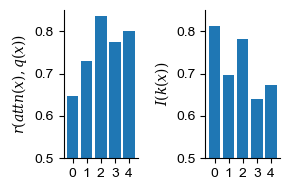

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(3, 2))
axes[0].bar(range(len(res.squeeze())), res.squeeze())
axes[0].set_ylabel('$r(attn(x), q(x))$')
axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].set_xticklabels(["0", "1", "2", "3", "4"])
axes[0].set_ylim([.5, .85])
axes[1].bar(range(len(moranis.squeeze())), moranis.squeeze())
axes[1].set_ylabel('$I(k(x))$')
axes[1].set_ylim([.5, .85])
axes[1].set_xticks([0, 1, 2, 3, 4])
axes[1].set_xticklabels(["0", "1", "2", "3", "4"])
plt.tight_layout()
for pos in ['right', 'top']:
    axes[0].spines[pos].set_visible(False)
    axes[1].spines[pos].set_visible(False)
plt.savefig("figures/sim1-ri.pdf")